In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
style.use('ggplot')

# on jupyterhub, comment this line
#dask.config.set({'distributed.dashboard.link': '/proxy/{port}/status'})

#### Dask stuff

In [4]:
# #DAV
# cluster = ncar_jobqueue.NCARCluster(cores=4, memory='24 GB')
# client = dask.distributed.Client(cluster)
# n_workers = 9 * 4
# cluster.scale(n_workers)

In [5]:
# #for cheyenne cluster
# memory='60GB'

# cluster=PBSCluster(cores=36,processes=9,memory=memory,project='P93300670',queue='regular',walltime='01:30:00')
# #cluster.scale(1)

# client = Client(cluster)

# cluster.scale(numnodes*9)

In [6]:
# cluster = NCARCluster(project='ncgd0011')
# cluster.adapt(minimum=1, maximum=10, wait_count=30)
# cluster

In [7]:
# client = dask.distributed.Client(cluster)
# client

#### Unit conversions

In [8]:
nmols_to_Pgyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

#### Get the CESM tseries files for nutrients and other vars

In [9]:
path = '/glade/scratch/klindsay/archive/g.e21.G1850ECOIAF.T62_g16.002/ocn/proc/tseries/month_1'
#path = '/glade/scratch/klindsay/archive/g.e21.G1850ECOIAF.T62_g16.003/ocn/proc/tseries/month_1' 

In [10]:
case = 'g.e21.G1850ECOIAF.T62_g16.002'

In [11]:
variables = ['NO3', 'PO4', 'SiO3','AOU','O2']

In [12]:
coords = {'x':'TLONG','y':'TLAT'}

In [13]:
keepthese = ['z_t','z_t_150m','time_bound','TAREA','REGION_MASK', 'time']

In [14]:
%%time
variables = ['AOU','NO3', 'PO4', 'SiO3','O2']

ds_list = []

print(f'reading {case}')

ds = xr.Dataset()

for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.??????-??????.nc'))       

    #print(files)
    
    #dsv = xr.open_mfdataset(files, decode_times=True, decode_coords=False)
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e21.G1850ECOIAF.T62_g16.002
AOU
NO3
PO4
SiO3
O2
CPU times: user 2.83 s, sys: 330 ms, total: 3.16 s
Wall time: 5.67 s


#### Just keep the variables we need

In [13]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time','time_bound','TAREA','PO4','Fe','NO3','SiO3','AOU','O2','REGION_MASK']
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [14]:
ds

<xarray.Dataset>
Dimensions:      (d2: 2, nlat: 384, nlon: 320, time: 1488, z_t: 60, z_t_150m: 15)
Coordinates:
    TLAT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * time         (time) object 0001-02-01 00:00:00 ... 0125-01-01 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    dz           (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    TAREA        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    KMT          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    REGION_MASK  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    time_bound   (time, d2) object dask.array<chunksize=(744, 2), meta=np.ndarray>
  

#### Fix the time dimension so it's the mean of the time bounds

In [15]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

#### Get the World Ocean Atlas dataset that has been interpolated onto the POP grid

In [16]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA_POPgrid.nc'

In [17]:
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

#### reset the WOA depth dimension as it's slightly different from CESM one

In [18]:
z_t = ds.z_t

In [19]:
ds_woa['z_t'] = z_t

#### Make annual mean variables for the last ten years of the model simulation

In [20]:
ds_annmean = xr.Dataset()
ds_annmean['NO3'] = ds.NO3.isel(time=slice(-120,1488)).mean(dim='time')
ds_annmean['PO4'] = ds.PO4.isel(time=slice(-120,1488)).mean(dim='time')
ds_annmean['SiO3'] = ds.SiO3.isel(time=slice(-120,1488)).mean(dim='time')
ds_annmean['AOU'] = ds.AOU.isel(time=slice(-120,1488)).mean(dim='time')
ds_annmean['O2'] = ds.O2.isel(time=slice(-120,1488)).mean(dim='time')

In [21]:
# ds_annmean_first30yrs = ds.isel(time=slice(0,12*30)).resample({'time':'A'}).mean(dim='time')
# ds_annmean_first30yrs

#### Make difference arrays for the nutrients, O$_2$, and AOU

In [22]:
NO3_diff = ds_annmean.NO3 - ds_woa.NO3
PO4_diff = ds_annmean.PO4 - ds_woa.PO4
SiO3_diff = ds_annmean.SiO3 - ds_woa.SiO3
AOU_diff = ds_annmean.AOU - ds_woa.AOU
O2_diff = ds_annmean.O2 - ds_woa.O2

#### Set up the longs and lons for plotting

In [23]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

#### -------------------------

#### Macronutrient maps

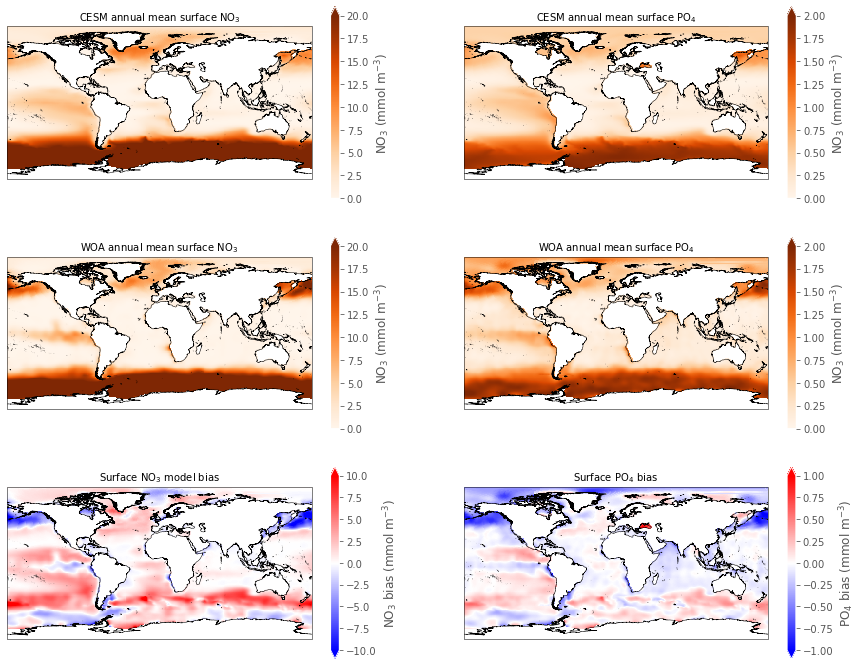

In [21]:
fig = plt.figure(figsize=(15,12))

#COLUMN 1  - NO3

#---- CESM panel
ax = fig.add_subplot(3,2,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_annmean.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,2,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,2,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 NO3_diff.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')

#---- CESM panel
ax = fig.add_subplot(3,2,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_annmean.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,2,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,2,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 PO4_diff.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



#### Global mean nutrient profiles

In [22]:
ds_glb = xr.Dataset({v: ds[v] for v in ['time', 'time_bound']})

In [23]:
ds_glb['NO3']= esmlab.weighted_mean(ds_annmean['NO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb['PO4']= esmlab.weighted_mean(ds_annmean['PO4'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb['SiO3']= esmlab.weighted_mean(ds_annmean['SiO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb['O2']= esmlab.weighted_mean(ds_annmean['O2'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb['AOU']= esmlab.weighted_mean(ds_annmean['AOU'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

In [24]:
#ds_glb.NO3.plot(y='z_t', yincrease=False) #this is a quick plot for depth profile

In [25]:
woa_no3_depth_global = esmlab.weighted_mean(ds_woa['NO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
woa_po4_depth_global = esmlab.weighted_mean(ds_woa['PO4'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
woa_sio3_depth_global = esmlab.weighted_mean(ds_woa['SiO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
woa_o2_depth_global = esmlab.weighted_mean(ds_woa['O2'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
woa_aou_depth_global = esmlab.weighted_mean(ds_woa['AOU'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

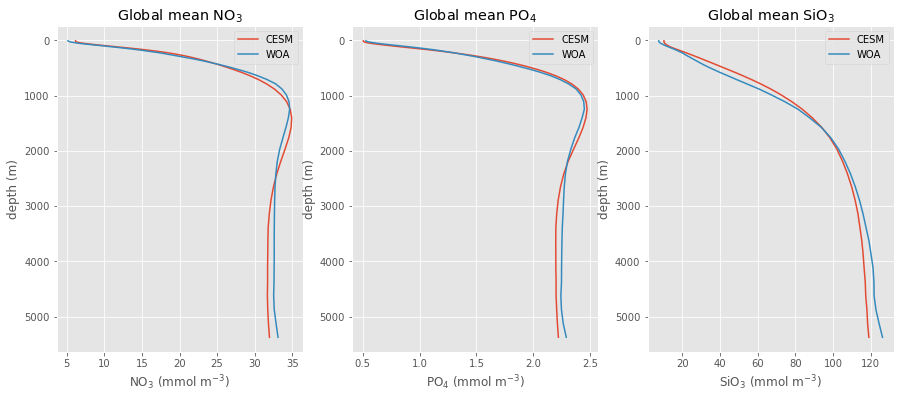

In [26]:
fig = plt.figure(figsize=(15,6))

#COLUMN 1  - NO3

ax = fig.add_subplot(1,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb['NO3'].values, depths, label='CESM')
ax.plot(woa_no3_depth_global.values, depths, label='WOA')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(1,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb['PO4'].values, depths, label='CESM')
ax.plot(woa_po4_depth_global.values, depths, label='WOA')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(1,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb['SiO3'].values, depths, label='CESM')
ax.plot(woa_sio3_depth_global.values, depths, label='WOA')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#### Just plotting the upper 200m

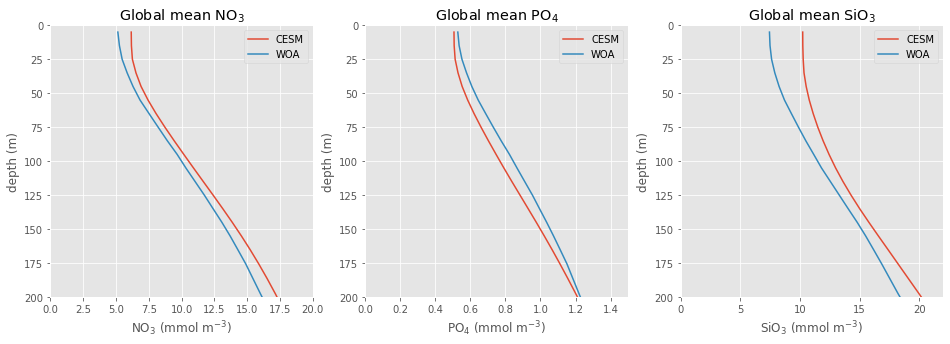

In [27]:
fig = plt.figure(figsize=(16,5))

#COLUMN 1  - NO3

ax = fig.add_subplot(1,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb['NO3'].values, depths, label='CESM')
ax.plot(woa_no3_depth_global.values, depths, label='WOA')
ax.legend()
ax.set_ylim(0,200)
ax.set_xlim(0,20)
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(1,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb['PO4'].values, depths, label='CESM')
ax.plot(woa_po4_depth_global.values, depths, label='WOA')
ax.legend()
ax.set_ylim(0,200)
ax.set_xlim(0,1.5)
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(1,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb['SiO3'].values, depths, label='CESM')
ax.plot(woa_sio3_depth_global.values, depths, label='WOA')
ax.legend()
ax.set_ylim(0,200)
ax.set_xlim(0,22)
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

### Oxygen profile

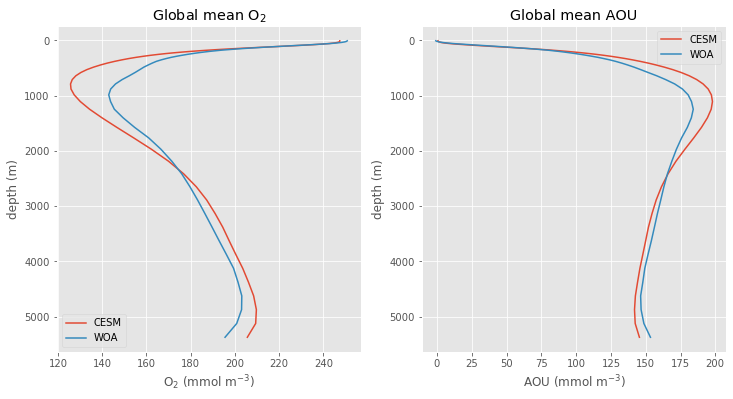

In [28]:
fig = plt.figure(figsize=(12,6))

#COLUMN 1  - O2

ax = fig.add_subplot(1,2,1)
ax.set_title('Global mean O$_2$')
ax.plot(ds_glb['O2'].values, depths, label='CESM')
ax.plot(woa_o2_depth_global.values, depths, label='WOA')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - AOU

ax = fig.add_subplot(1,2,2)
ax.set_title('Global mean AOU')
ax.plot(ds_glb['AOU'].values, depths, label='CESM')
ax.plot(woa_aou_depth_global.values, depths, label='WOA')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='AOU (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#### Regional nutrient profiles

In [23]:
grid_name = 'POP_gx1v7'
ds_regmasks = pop_tools.get_grid(grid_name)

In [30]:
region_masks = pop_tools.list_region_masks(grid_name)
region_masks

['lat-range-basin', 'Pacific-Indian-Atlantic']

In [31]:
def visualize_mask(mask3d):
    nregion = len(mask3d.region)

    # mask out land
    mask3d = mask3d.where(ds.KMT > 0)

    # visualize the regions
    ncol = int(np.sqrt(nregion))
    nrow = int(nregion/ncol) + min(1, nregion%ncol)

    fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                           constrained_layout=True)

    for i, region in enumerate(mask3d.region.values):
        plt.axes(ax.ravel()[i])
        mask3d.sel(region=region).plot()

    # delete the unused axes
    for i in range(nregion, ncol*nrow):
        fig.delaxes(ax.ravel()[i])

    fig.suptitle(f'Mask name = {mask3d.mask_name}', fontsize=16)

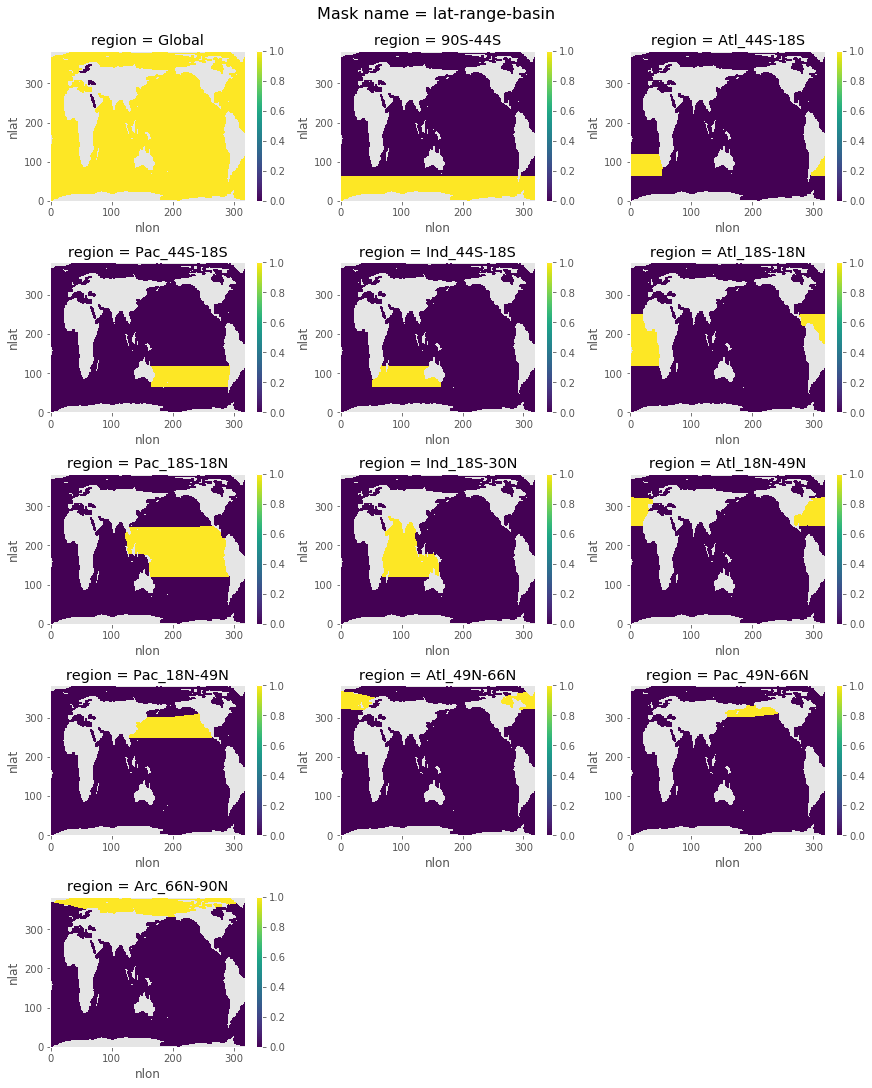

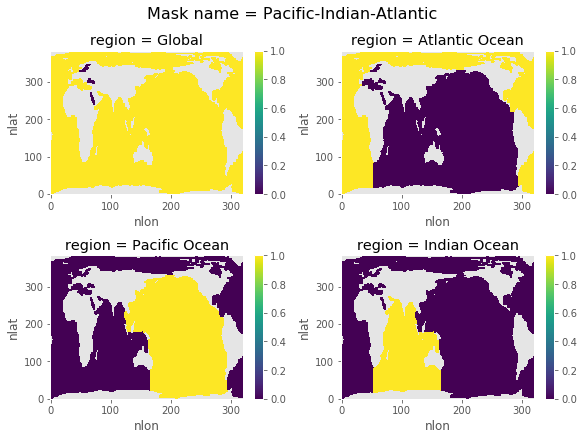

In [32]:
for region_mask in region_masks:
    mask3d = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)
    visualize_mask(mask3d)

In [31]:
region_mask='Pacific-Indian-Atlantic'
mask3d = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)

### Let's look at nuts in the Pacific first

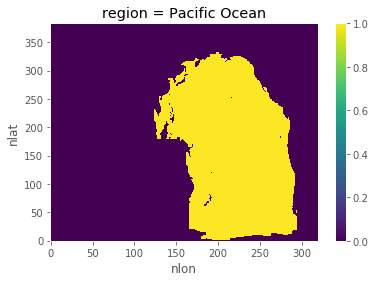

In [34]:
regnum=2
mask3d.isel(region=regnum).plot();

In [35]:
ds_pac = xr.Dataset({v: ds[v] for v in ['time', 'time_bound']})

In [36]:
ds_pac['NO3']= esmlab.weighted_mean(ds_annmean['NO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac['PO4']= esmlab.weighted_mean(ds_annmean['PO4']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac['SiO3']= esmlab.weighted_mean(ds_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

In [37]:
woa_no3_depth_pac = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
woa_po4_depth_pac = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
woa_sio3_depth_pac = esmlab.weighted_mean(ds_woa['SiO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

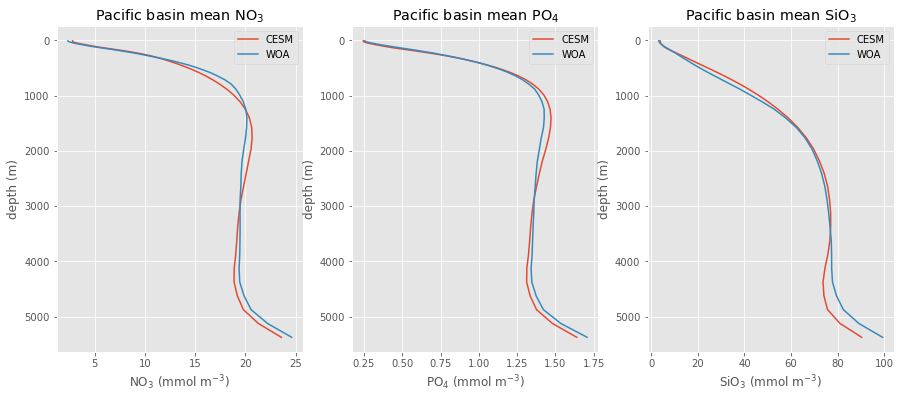

In [38]:
fig = plt.figure(figsize=(15,6))

#COLUMN 1  - NO3

ax = fig.add_subplot(1,3,1)
ax.set_title('Pacific basin mean NO$_3$')
ax.plot(ds_pac['NO3'].values, depths, label='CESM')
ax.plot(woa_no3_depth_pac.values, depths, label='WOA')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(1,3,2)
ax.set_title('Pacific basin mean PO$_4$')
ax.plot(ds_pac['PO4'].values, depths, label='CESM')
ax.plot(woa_po4_depth_pac.values, depths, label='WOA')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(1,3,3)
ax.set_title('Pacific basin mean SiO$_3$')
ax.plot(ds_pac['SiO3'].values, depths, label='CESM')
ax.plot(woa_sio3_depth_pac.values, depths, label='WOA')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

### Let's look at nuts in the Atlantic

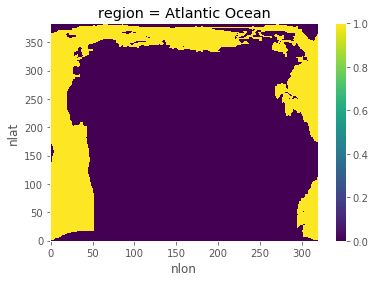

In [39]:
regnum=1
mask3d.isel(region=regnum).plot();

In [40]:
ds_atl = xr.Dataset({v: ds[v] for v in ['time', 'time_bound']})
ds_atl_woa = xr.Dataset({v: ds[v] for v in ['time', 'time_bound']})

In [41]:
ds_atl['NO3']= esmlab.weighted_mean(ds_annmean['NO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl['PO4']= esmlab.weighted_mean(ds_annmean['PO4']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl['SiO3']= esmlab.weighted_mean(ds_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl['O2']= esmlab.weighted_mean(ds_annmean['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl['AOU']= esmlab.weighted_mean(ds_annmean['AOU']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()


In [42]:
ds_atl_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['AOU'] = esmlab.weighted_mean(ds_woa['AOU']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

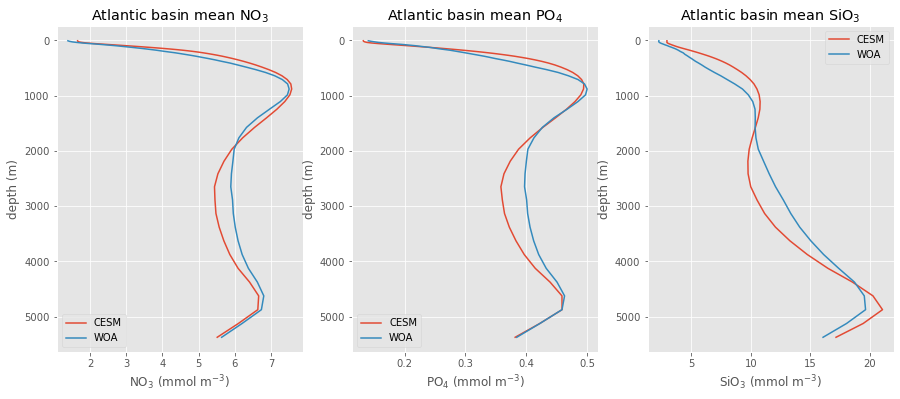

In [101]:
fig = plt.figure(figsize=(15,6))

#COLUMN 1  - NO3

ax = fig.add_subplot(1,3,1)
ax.set_title('Atlantic basin mean NO$_3$')
ax.plot(ds_atl['NO3'].values, depths, label='CESM')
ax.plot(ds_atl_woa['NO3'].values, depths, label='WOA')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(1,3,2)
ax.set_title('Atlantic basin mean PO$_4$')
ax.plot(ds_atl['PO4'].values, depths, label='CESM')
ax.plot(ds_atl_woa['PO4'].values, depths, label='WOA')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(1,3,3)
ax.set_title('Atlantic basin mean SiO$_3$')
ax.plot(ds_atl['SiO3'].values, depths, label='CESM')
ax.plot(ds_atl_woa['SiO3'].values, depths, label='WOA')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#### Look at O$_2$ in the Atlantic

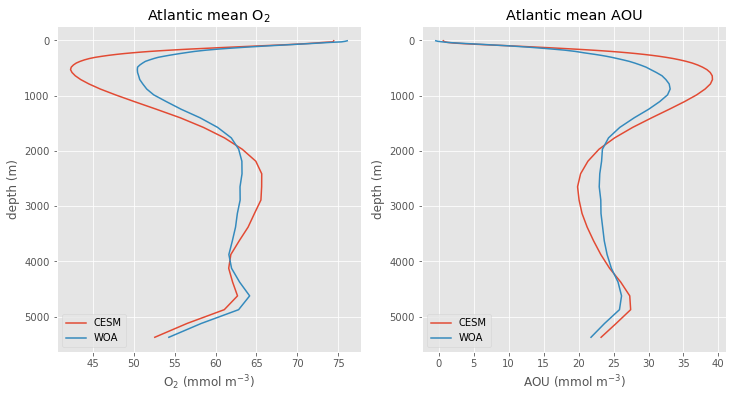

In [43]:
fig = plt.figure(figsize=(12,6))

#COLUMN 1  - O2

ax = fig.add_subplot(1,2,1)
ax.set_title('Atlantic mean O$_2$')
ax.plot(ds_atl['O2'].values, depths, label='CESM')
ax.plot(ds_atl_woa['O2'].values, depths, label='WOA')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - AOU

ax = fig.add_subplot(1,2,2)
ax.set_title('Atlantic mean AOU')
ax.plot(ds_atl['AOU'].values, depths, label='CESM')
ax.plot(ds_atl_woa['AOU'].values, depths, label='WOA')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='AOU (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

## Calculate tendencies in O$_2$ over the first 30 years

#### Make annual mean data over the first 30 years

In [21]:
ds_annmean_first30yrs = ds.isel(time=slice(0,12*30)).resample({'time':'A'}).mean(dim='time')
ds_annmean_first30yrs

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, time: 30, z_t: 60, z_t_150m: 15)
Coordinates:
  * time         (time) object 0001-12-31 00:00:00 ... 0030-12-31 00:00:00
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... nan nan nan
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... nan nan nan
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    dz           (time, z_t) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    TAREA        (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    KMT          (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    REGION_MASK  (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    AOU          (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320

#### First make regional timeseries of O$_2$, again use the region mask for the 3 ocean basins

In [24]:
region_mask='Pacific-Indian-Atlantic'
mask3d = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)

First do the Atlantic

In [25]:
ts_Atl = xr.Dataset({v: ds_annmean_first30yrs[v] for v in ['time', 'z_t']})

In [26]:
regnum=1
ts_Atl['O2'] = esmlab.weighted_mean(ds_annmean_first30yrs['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

In [27]:
ts_Atl_O2_surf = ts_Atl.O2.isel(z_t=0).data

Now do Pacific

In [28]:
ts_Pac = xr.Dataset({v: ds_annmean_first30yrs[v] for v in ['time', 'z_t']})

In [29]:
regnum=2
ts_Pac['O2'] = esmlab.weighted_mean(ds_annmean_first30yrs['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

In [30]:
ts_Pac_O2_surf = ts_Pac.O2.isel(z_t=0).data

Now do Indian

In [31]:
ts_Ind = xr.Dataset({v: ds_annmean_first30yrs[v] for v in ['time', 'z_t']})

In [32]:
regnum=3
ts_Ind['O2'] = esmlab.weighted_mean(ds_annmean_first30yrs['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

In [33]:
ts_Ind_O2_surf = ts_Ind.O2.isel(z_t=0).data

#### Now that the regional timeseries are made, take the trend

In [36]:
# from statistics import mean
# from matplotlib import style
# from scipy import stats
# style.use('ggplot')

In [37]:
years = np.arange(30) + 1

In [38]:
atl_slope, atl_intercept, r_value, p_value, std_err = stats.linregress(years,ts_Atl_O2_surf)
atl_line = atl_slope * years + atl_intercept
atl_slope

-0.002797498003582683

In [39]:
ind_slope, ind_intercept, r_value, p_value, std_err = stats.linregress(years,ts_Ind_O2_surf)
ind_line = ind_slope * years + ind_intercept
ind_slope

-0.0033737341867679715

In [40]:
pac_slope, pac_intercept, r_value, p_value, std_err = stats.linregress(years,ts_Pac_O2_surf)
pac_line = pac_slope * years + pac_intercept
pac_slope

-0.004523961628096617

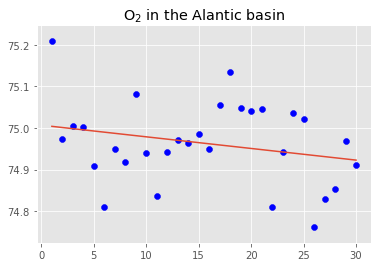

In [41]:
plt.scatter(years,ts_Atl_O2_surf,color='blue')
plt.plot(years, atl_line)
plt.title("O$_2$ in the Alantic basin")
plt.show()

[Text(0, 0.5, 'O$_2$ (mmol m$^{-3}$)'), Text(0.5, 0, 'year of simulation')]

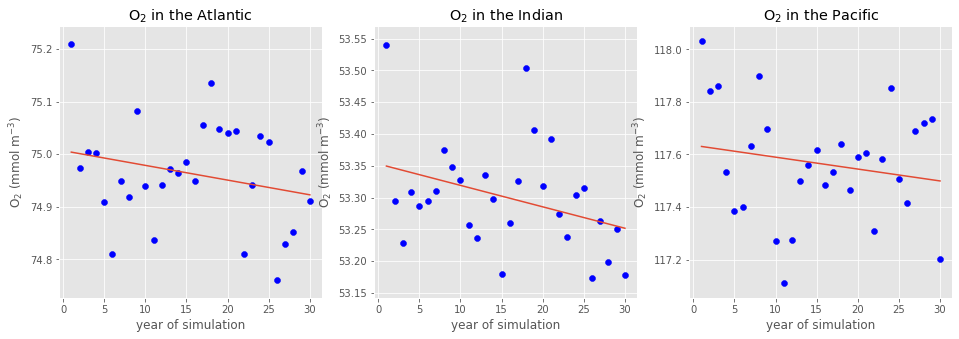

In [42]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,3,1)
ax.set_title('O$_2$ in the Atlantic')
ax.scatter(years,ts_Atl_O2_surf,color='blue')
ax.plot(years, atl_line)
ax.set(ylabel='O$_2$ (mmol m$^{-3}$)',xlabel='year of simulation')

ax = fig.add_subplot(1,3,2)
ax.set_title('O$_2$ in the Indian')
ax.scatter(years,ts_Ind_O2_surf,color='blue')
ax.plot(years, ind_line)
ax.set(ylabel='O$_2$ (mmol m$^{-3}$)',xlabel='year of simulation')

ax = fig.add_subplot(1,3,3)
ax.set_title('O$_2$ in the Pacific')
ax.scatter(years,ts_Pac_O2_surf,color='blue')
ax.plot(years, pac_line)
ax.set(ylabel='O$_2$ (mmol m$^{-3}$)',xlabel='year of simulation')



### How much do these slopes change if we use a longer timeseries to calculate them?

In [24]:
ds_annmean_first62yrs_surf = ds.isel(time=slice(0,12*62),z_t=0).resample({'time':'A'}).mean(dim='time')
ds_annmean_first62yrs_surf

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, time: 62, z_t_150m: 15)
Coordinates:
  * time         (time) object 0001-12-31 00:00:00 ... 0062-12-31 00:00:00
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... nan nan nan
    z_t          float32 500.0
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... nan nan nan
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TAREA        (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    dz           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    KMT          (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    REGION_MASK  (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    AOU          (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    NO3          (time, nlat, nlon) float32 dask

In [26]:
ts_Atl = xr.Dataset({v: ds_annmean_first62yrs_surf[v] for v in ['time']})

In [32]:
regnum=1
ts_Atl['O2'] = esmlab.weighted_mean(ds_annmean_first62yrs_surf['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

In [34]:
ts_Atl_O2_surf = ts_Atl.O2.data

In [35]:
ts_Pac = xr.Dataset({v: ds_annmean_first62yrs_surf[v] for v in ['time']})

In [36]:
regnum=2
ts_Pac['O2'] = esmlab.weighted_mean(ds_annmean_first62yrs_surf['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

In [37]:
ts_Pac_O2_surf = ts_Pac.O2.data

In [38]:
ts_Ind = xr.Dataset({v: ds_annmean_first62yrs_surf[v] for v in ['time']})

In [39]:
regnum=3
ts_Ind['O2'] = esmlab.weighted_mean(ds_annmean_first62yrs_surf['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

In [40]:
ts_Ind_O2_surf = ts_Ind.O2.data

In [41]:
years = np.arange(62) + 1

In [42]:
atl_slope, atl_intercept, r_value, p_value, std_err = stats.linregress(years,ts_Atl_O2_surf)
atl_line = atl_slope * years + atl_intercept
atl_slope

-0.010281042946690244

In [43]:
ind_slope, ind_intercept, r_value, p_value, std_err = stats.linregress(years,ts_Ind_O2_surf)
ind_line = ind_slope * years + ind_intercept
ind_slope

-0.002648619407858368

In [44]:
pac_slope, pac_intercept, r_value, p_value, std_err = stats.linregress(years,ts_Pac_O2_surf)
pac_line = pac_slope * years + pac_intercept
pac_slope

-0.010377973048711613

[Text(0, 0.5, 'O$_2$ (mmol m$^{-3}$)'), Text(0.5, 0, 'year of simulation')]

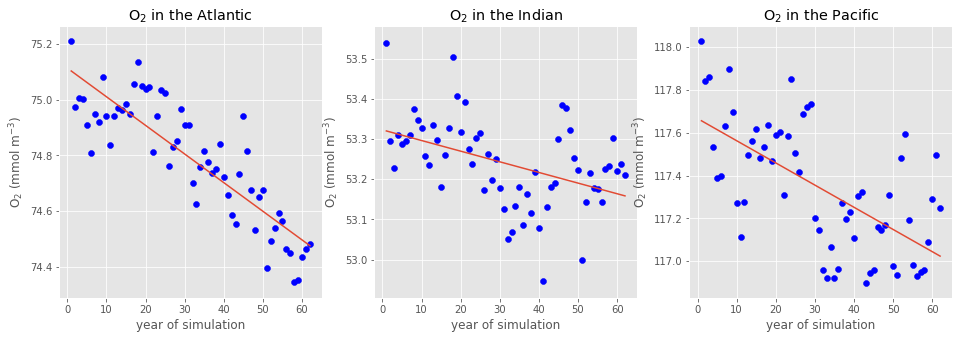

In [46]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,3,1)
ax.set_title('O$_2$ in the Atlantic')
ax.scatter(years,ts_Atl_O2_surf,color='blue')
ax.plot(years, atl_line)
ax.set(ylabel='O$_2$ (mmol m$^{-3}$)',xlabel='year of simulation')

ax = fig.add_subplot(1,3,2)
ax.set_title('O$_2$ in the Indian')
ax.scatter(years,ts_Ind_O2_surf,color='blue')
ax.plot(years, ind_line)
ax.set(ylabel='O$_2$ (mmol m$^{-3}$)',xlabel='year of simulation')

ax = fig.add_subplot(1,3,3)
ax.set_title('O$_2$ in the Pacific')
ax.scatter(years,ts_Pac_O2_surf,color='blue')
ax.plot(years, pac_line)
ax.set(ylabel='O$_2$ (mmol m$^{-3}$)',xlabel='year of simulation')

